In [ ]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir())

['.config', 'train.zip', 'sample_data']


In [ ]:
!unzip train.zip

Archive:  train.zip
   creating: train/apple/
  inflating: train/apple/apple_1_jpg.rf.4cacc5f4e5258f529913a52e6bd8fec3.jpg  
  inflating: train/apple/apple_1_jpg.rf.e5eeb1a54b5ab2bb64597f62ea0b25b8.jpg  
  inflating: train/apple/apple_1_jpg.rf.f125405284c1bc499129ddf91c23d5bf.jpg  
  inflating: train/apple/apple_10_jpg.rf.815eccb5bf9ed26bb52f5f7b680f3f6e.jpg  
  inflating: train/apple/apple_10_jpg.rf.99e696c89f481c77b71e1c08127d8835.jpg  
  inflating: train/apple/apple_10_jpg.rf.ca09c601b1864f90b7991ddf5ce627a4.jpg  
  inflating: train/apple/apple_11_jpg.rf.2158a4a5397d9360f42f16dacccf39bd.jpg  
  inflating: train/apple/apple_11_jpg.rf.31c51b8712fb523703959eb0ddc68ec8.jpg  
  inflating: train/apple/apple_11_jpg.rf.c1a3a17b5ea63d64ffa6ed87e719a84a.jpg  
  inflating: train/apple/apple_12_jpg.rf.0bc42269861b6b3c149709ff04b327c2.jpg  
  inflating: train/apple/apple_12_jpg.rf.198609b6af07559a7086d3dec72838ef.jpg  
  inflating: train/apple/apple_12_jpg.rf.a2bf9d98c4333664ccfe4dbc5edd18fe.jpg

In [ ]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
BATCH_SIZE=32

In [ ]:
filenames = os.listdir("train")

In [ ]:
filenames

['korean_pancake',
 'cucumber',
 'broccoli',
 'butter',
 'kiwi',
 'banana',
 'radish',
 'bread',
 'fruit_jam',
 'watermelon',
 'apple',
 'cabbage',
 'eggplant',
 'powder',
 'carrot',
 'tomato',
 'lettuce',
 'sauce',
 'onion',
 'avocado',
 'potato',
 'bell_pepper',
 'mushroom',
 'persimmon']

In [ ]:
import tensorflow as tf

In [ ]:
df = tf.keras.utils.image_dataset_from_directory(
    'train',
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 2156 files belonging to 24 classes.
Using 1725 files for training.


In [ ]:
df

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization()) # 사용시에 대체적으로 성능이 증가, 배치 정규화
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        2

In [ ]:
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5)) # 과적합 줄임
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        2

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
earlystop = EarlyStopping(patience=10)

In [ ]:
# annealing
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
# val 데이터의 정확도를 모니터링(주로 val_loss 사용?)
# 2 에폭동안 모델 성능이 개선되지 않으면 콜백함수 호출
# 콜백함수 호출되면 학습률(lr) 0.5(1/2배)로 줄임 -> 모델의 개선 유도
# min_lr : 하한선
# 통상적인 초기 러닝레이트 0.001, 0.0001
# 늘려가거나 줄여가면서
# default 값(optimizer 따라 설정되어잇음) (keras 문서에서 확인가능)

In [ ]:
callbacks = [earlystop, learning_rate_reduction]

NameError: name 'bb' is not defined

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

In [ ]:
# CIFAR-10 데이터 로드
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [ ]:
len(train_images)

50000

In [ ]:
len(test_images)

10000

In [ ]:
# 클래스 레이블 정의
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
# 이미지 표시
def plot_images(images, labels):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.xlabel(class_names[labels[i][0]])

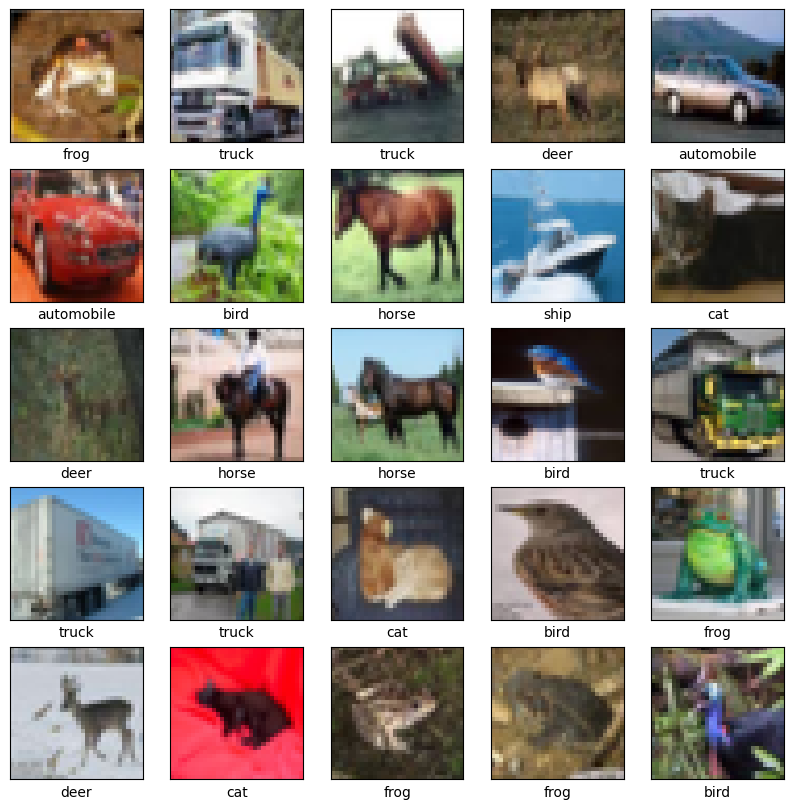

In [ ]:
plot_images(train_images, train_labels)
plt.show()

In [ ]:
from tensorflow import keras
from keras.datasets import cifar10
import numpy as np

In [ ]:
# 데이터 정규화
train_images = train_images / 255.0
test_images = test_images / 255.0

In [ ]:
train_images

array([[[[0.23137255, 0.24313725, 0.24705882],
         [0.16862745, 0.18039216, 0.17647059],
         [0.19607843, 0.18823529, 0.16862745],
         ...,
         [0.61960784, 0.51764706, 0.42352941],
         [0.59607843, 0.49019608, 0.4       ],
         [0.58039216, 0.48627451, 0.40392157]],

        [[0.0627451 , 0.07843137, 0.07843137],
         [0.        , 0.        , 0.        ],
         [0.07058824, 0.03137255, 0.        ],
         ...,
         [0.48235294, 0.34509804, 0.21568627],
         [0.46666667, 0.3254902 , 0.19607843],
         [0.47843137, 0.34117647, 0.22352941]],

        [[0.09803922, 0.09411765, 0.08235294],
         [0.0627451 , 0.02745098, 0.        ],
         [0.19215686, 0.10588235, 0.03137255],
         ...,
         [0.4627451 , 0.32941176, 0.19607843],
         [0.47058824, 0.32941176, 0.19607843],
         [0.42745098, 0.28627451, 0.16470588]],

        ...,

        [[0.81568627, 0.66666667, 0.37647059],
         [0.78823529, 0.6       , 0.13333333]

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

In [ ]:
model = Sequential()

